In [1]:
!pip install mss
!pip install matplotlib
!pip install tensorboardX

In [2]:
# debug
import time
import random
from IPython.display import clear_output

### get_frame

In [3]:
from win32gui import FindWindow, GetWindowRect, SetForegroundWindow, GetForegroundWindow, GetWindowText
import win32com.client

shell = win32com.client.Dispatch("WScript.Shell")

# FindWindow takes the Window Class name (can be None if unknown), and the window's display text. 
window_handle = FindWindow(None, "game - Snes9x 1.62.3")
window_rect   = GetWindowRect(window_handle)
print(window_rect)
window_offset = (200, 200, -10, -70)

window_rect = tuple(p + o for p, o in zip(window_rect, window_offset))

print(window_rect)
#(0, 0, 800, 600)


(1370, 282, 1890, 781)
(1570, 482, 1880, 711)


In [4]:
import mss.tools, numpy as np
from matplotlib import pyplot as plt

def set_foreground_game():
    shell.SendKeys('%')
    SetForegroundWindow(window_handle)

def get_frame():
    with mss.mss() as sct:
        img = sct.grab(window_rect)
    return np.array(img)[:, :, :3]

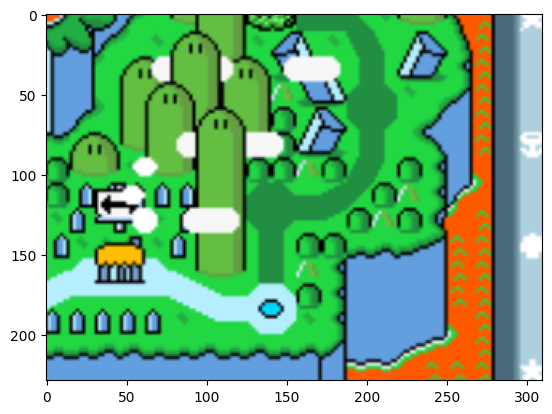

In [5]:
set_foreground_game()
frame = get_frame()
plt.imshow(frame)

### read memory

In [6]:
import win32api
import win32process
import win32con
import ctypes


def get_process_by_name(process_name):
    """Finds the process id of the given
    process name and returns the process id and its base address."""

    process_name = process_name.lower()

    # Enumerate all processes
    processes = win32process.EnumProcesses()

    for process_id in processes:
        # If process_id is the same as this program, skip it
        if process_id == -1:
            continue

        # Try to read the process memory
        try:
            h_process = win32api.OpenProcess(win32con.PROCESS_QUERY_INFORMATION | win32con.PROCESS_VM_READ, True, process_id)

            # Try to read the modules of the process
            try:
                # modules is an array of base addresses of each module
                modules = win32process.EnumProcessModules(h_process)

                for base_address in modules:
                    # Get the name of the module
                    name = str(win32process.GetModuleFileNameEx(h_process, base_address))

                    # Compare it to the name of your program
                    if name.lower().find(process_name) != -1:
                        return process_id, base_address
            finally:
                win32api.CloseHandle(h_process)
        except:
            pass


def read_process_memory(process_id, address, offsets=[]):
    """Read a process' memory based on its process id, address and offsets.
    Returns the address without offsets and the value."""

    # The handle to the program's process
    # This will allow to use ReadProcessMemory
    h_process = ctypes.windll.kernel32.OpenProcess(win32con.PROCESS_VM_READ, False, p_id)

    # This is a pointer to the data you want to read
    # Use `data.value` to get the value at this pointer
    # In this case, this value is an Integer with 4 bytes
    data = ctypes.c_uint(0)

    # Size of the variable, it usually is 4 bytes
    bytesRead = ctypes.c_uint(0)

    # Starting address
    current_address = address

    if offsets:
        # Append a new element to the offsets array
        # This will allow you to get the value at the last offset
        offsets.append(None)

        for offset in offsets:
            # Read the memory of current address using ReadProcessMemory
            ctypes.windll.kernel32.ReadProcessMemory(h_process, current_address, ctypes.byref(data), ctypes.sizeof(data), ctypes.byref(bytesRead))

            # If current offset is `None`, return the value of the last offset
            if not offset:
                return current_address, data.value
            else:
                # Replace the address with the new data address
                current_address = data.value + offset

    else:
        # Just read the single memory address
        ctypes.windll.kernel32.ReadProcessMemory(h_process, current_address, ctypes.byref(data), ctypes.sizeof(data), ctypes.byref(bytesRead))

    # Close the handle to the process
    ctypes.windll.kernel32.CloseHandle(h_process)

    # Return a pointer to the value and the value
    # The pointer will be used to write to the memory
    return current_address, data.value

In [7]:
p_id, base_address = get_process_by_name("snes9x.exe")
# 00012698
def get_current_life():
    return read_process_memory(p_id, base_address+0x0090F520, offsets=[0x90])[1]

def get_life_state():
    return read_process_memory(p_id, base_address+0x0090F520, offsets=[0xB4])[1]

def get_current_camera_pos():
    return read_process_memory(p_id, base_address+0x00012698, offsets=[0x18])[1]

get_current_camera_pos()

4293853184

### env

In [8]:
import win32api, win32con

VK_CODE = {
    'c': 0x43,
    'left_arrow':0x25,
    'up_arrow':0x26,
    'right_arrow':0x27,
    'down_arrow':0x28,
    'x':0x58,
    'F1':0x70,
    
}

def press_key(key):
    win32api.keybd_event(VK_CODE[key], win32api.MapVirtualKey(VK_CODE[key], 0), 0, 0)

def release_key(key):
    win32api.keybd_event(VK_CODE[key], win32api.MapVirtualKey(VK_CODE[key], 0), win32con.KEYEVENTF_KEYUP, 0)


class GameController:
    def __init__(self):
        self.reset()
    
    def reset(self):
        press_key('F1')
        time.sleep(0.25)
        release_key('F1')

        self.mario_current_life_state = get_life_state()
        self.last_camera_pos = get_current_camera_pos()
        return get_frame() # obs


    def step(self, action):
        reward = 0
        game_over = False
        
        if GetForegroundWindow() != window_handle:
            raise Exception(f"{GetWindowText(window_handle)} cannot be minimized.") 

        if action == 0:
            release_key('left_arrow')
            press_key('right_arrow')
            release_key('x')
            release_key('c')
        if action == 1:
            release_key('right_arrow')
            press_key('left_arrow')
            release_key('x')
            release_key('c')
        
        if action == 2:
            press_key('c')
        
        if action == 3:
            press_key('x')

        time.sleep(0.1)

        current_camera_pos = get_current_camera_pos()
        reward += 1 if current_camera_pos > self.last_camera_pos else -1
        # reward += -1 if current_camera_pos < self.last_camera_pos else 0
        self.last_camera_pos = current_camera_pos

        if self.mario_current_life_state != get_life_state():
            reward = -10
            game_over = True
        # time.sleep(0.1)
        return [
            get_frame(), # obs
            reward, # reward
            game_over, # game_over
        ]

In [9]:
controller = GameController()

### Agent

In [10]:
import torch
import torchvision

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [11]:
D = 200_000
GAMMA = 0.95
LR = 0.00001

NUM_EPISODES = 50
SEQUENCE_LENGTH = 4
BATCH_SIZE = 128

EPS_NUM_STEPS = 1000
EPS_START = 0.99
EPS_END = 0.1
EPS_DECAY = (EPS_START - EPS_END) / (EPS_NUM_STEPS)


action_space = 4

load_model = False
model_name = "2023_04_17_06_38_10"

In [12]:

from collections import deque
from itertools import islice
import random

CROP_DIMS = 60, 40, 95, 95
RESIZE = 80, 80

class Memory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque([], maxlen=capacity)
    
    def __len__(self):
        return len(self.memory)
    
    def push(self, experience):
        self.memory.append(experience)
    
    # for replay memory
    def sample(self, batch_size): # maybe separate by episode to avoid sequence where final_state -> start_state
        rand_range = random.randint(batch_size, len(self.memory))
        return list(islice(self.memory, rand_range - batch_size, rand_range))
    
    # for sequence
        
    def render(self):
        if len(self.memory) < SEQUENCE_LENGTH:
            return False, None
        x = torch.stack(tuple(self.memory))
        return True, x
    
    def clear(self):
        self.memory.clear()

(229, 310, 3)
(80, 80, 1)


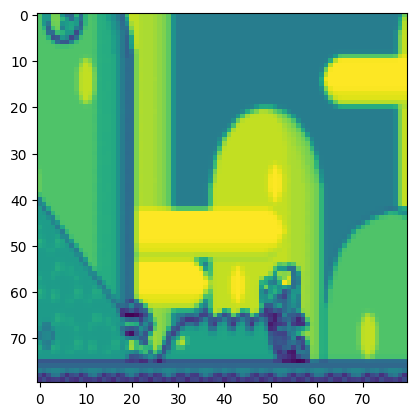

In [13]:
def phi(observation):
    x = observation.transpose([2, 0, 1])
    x = torch.tensor(x, dtype=torch.float32, device=device)/255
    # x = torchvision.transforms.functional.crop(x, *CROP_DIMS)
    x = torchvision.transforms.Grayscale()(x)
    x = torchvision.transforms.Resize(RESIZE, antialias=True)(x)
    # x = torchvision.transforms.Normalize(mean=x.mean(), std=x.std())(x)
    return x


set_foreground_game()
observation = controller.reset()
print(observation.shape)
x = phi(observation).cpu().numpy().transpose([1,2,0])
print(x.shape)
plt.imshow(x)
plt.show()

In [14]:
def batch_images(batch):
    grid = torchvision.utils.make_grid(batch)
    grid = grid.cpu().numpy()
    plt.imshow(grid.transpose([1,2,0]))
    plt.show()
    
def forwad_batch_images(batch):
    batch = batch.unsqueeze(0)
    batch = batch.transpose(0,1)
    grid = torchvision.utils.make_grid(batch)
    grid = grid.cpu().detach().numpy()
    plt.imshow(grid.transpose([1,2,0]))
    plt.show()

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        # 3x40x40
        self.conv_0 = nn.Conv2d(1, 12, (2, 2), stride=1) # 3x37x37
        self.maxpool_1 = nn.MaxPool2d(2, stride=2)
        self.conv_1 = nn.Conv2d(12, 24, (3, 3), stride=1) # 4x6x6
        self.maxpool_2 = nn.MaxPool2d(2, stride=2)
        self.conv_2 = nn.Conv2d(24, 48, (3, 3), stride=1) # 4x6x6
        self.maxpool_3 = nn.MaxPool2d(2, stride=2)
        self.conv_3 = nn.Conv2d(48, 48, (3, 3), stride=1) # 4x6x6
        self.maxpool_4 = nn.MaxPool2d(2, stride=2)
        self.flatten = nn.Flatten() # 4x6x6
        
        self.lstm = nn.LSTM(432, 256, 1, batch_first=True)
        
        self.v = nn.Linear(256, 1)
        self.a = nn.Linear(256, action_space)
        
    def forward(self, x, hn, cn):
        batch_size = x.shape[0]
        x = x.reshape((-1, 1, x.shape[-2], x.shape[-1]))
        x = F.relu(self.conv_0(x))
        x = self.maxpool_1(x)
        x = F.relu(self.conv_1(x))
        x = self.maxpool_2(x)
        x = F.relu(self.conv_2(x))
        x = self.maxpool_3(x)
        x = F.relu(self.conv_3(x))
        x = self.maxpool_4(x)
        x = x.reshape((batch_size, -1, x.shape[-3], x.shape[-2], x.shape[-1]))
        x = torch.flatten(x, 2)
        x, (hn, cn) = self.lstm(x, (hn, cn))
        x = x[:,-1,:]
        a = self.a(x)
        v = self.v(x)
        q = v + a - a.mean()
        return q, hn, cn
    
    
    def q_train(self, target_net, optimizer, loss_fn, sequence):
        states, actions, rewards, next_states = *zip(*sequence), # let the ',' to not give syntax error
        
        states = torch.stack(states)
        actions = torch.cat(actions)
        rewards = torch.cat(rewards)
        
        # next_states = torch.stack(next_states)
        non_final_states_mask = torch.tensor(tuple(map(lambda s: s is not None, next_states)), device=device)
        #non_final_next_states = next_states[non_final_states_mask]
        non_final_next_states = torch.stack([s for s in next_states if s is not None])

        hn = torch.zeros(1, BATCH_SIZE, 256, dtype=torch.float32, device=device) #requires gRAR?A?FAS?FAS?DSA
        cn = torch.zeros(1, BATCH_SIZE, 256, dtype=torch.float32, device=device)
        max_action_qvalues = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            non_final_next_states = non_final_next_states
            output = target_net(non_final_next_states, hn[:,non_final_states_mask], cn[:,non_final_states_mask])
            y, hn, cn = output
            y_max = y.max(1)[0]
            max_action_qvalues[non_final_states_mask] = y_max
            
        # Set yj for terminal and non-terminal phij+1
        y = rewards + GAMMA * max_action_qvalues
        
        hn = torch.zeros(1, BATCH_SIZE, 256, dtype=torch.float32, device=device, requires_grad=True)
        cn = torch.zeros(1, BATCH_SIZE, 256, dtype=torch.float32, device=device, requires_grad=True)
        qvalues, hn, cn = self(states, hn, cn)

            


        qvalues = qvalues.gather(1, actions)
        loss = loss_fn(qvalues, y.unsqueeze(1))
        optimizer.zero_grad()
        
        loss.backward()
        
        torch.nn.utils.clip_grad_value_(self.parameters(), 100)
        optimizer.step()
        
        return loss

In [16]:
import time
from itertools import count
from tensorboardX import SummaryWriter

timestr = time.strftime("%Y_%m_%d_%H_%M_%S")

# Initiliaze replay memory D to capacity N
replay_memory = Memory(D)
sequence = Memory(SEQUENCE_LENGTH)

# Initialize action-value function Q with random weights

policy_net = DQN().to(device) # used to store teta
target_net = DQN().to(device) # used to store teta-1

if load_model:
    policy_net.load_state_dict(torch.load(f'./saved_models/{model_name}/policy_net'))
    
target_net.load_state_dict(policy_net.state_dict())

optimizer = torch.optim.Adam(policy_net.parameters(), lr=LR)
loss_fn = nn.MSELoss()

epsilon = EPS_START
steps = 0
episode = 0

In [17]:
time.sleep(2)

if GetForegroundWindow() != window_handle:
    set_foreground_game()

time.sleep(1)
controller = GameController()

with SummaryWriter(logdir="runs/"+timestr) as writer:
    
    while steps < D*10 -50:
        
        ep_rewards = 0
        ep_qvalues = 0
        ep_loss = 0
        
        # Initialise sequence s1 = {x1} and preprocessed sequenced φ1 = φ(s1)
        observation = controller.reset()
        state = phi(observation)
        last_reward = 0
        sequence.clear()
        sequence.push(state)
        
        rendered, sequence_state = sequence.render()
        
        for t in count():

            hn = torch.zeros(1, 1, 256, dtype=torch.float32, device=device)
            cn = torch.zeros(1, 1, 256, dtype=torch.float32, device=device)
            with torch.no_grad():
                if rendered:
                    q_value_action, hn, cn = policy_net(sequence_state.unsqueeze(0), hn, cn)
                    q_value_action = q_value_action.max(1)
                    ep_qvalues += q_value_action[0].item()
                else:
                    action = torch.tensor([[random.randint(0, action_space-1)]], device=device, dtype=torch.long)
                
            
            # With probability eps select a random action at
            epsilon = epsilon - EPS_DECAY if epsilon > EPS_END else EPS_END
            if random.uniform(0, 1) < epsilon:
                action = torch.tensor([[random.randint(0, action_space-1)]], device=device, dtype=torch.long)
            # otherwise select at = maxaQ*(phi(st), a; teta)
            else:
                if rendered:
                    action = q_value_action[1].view(1,1)
                    # print(action)

            # Execute action at in emulator and observe reward rt and image xt+1
            observation, reward, game_over = controller.step(action.item())
            
            # reward -= 0.01
            ep_rewards += reward
            
            reward = torch.tensor([reward], device=device, dtype=torch.float32)
            
            # env.render()

            # Set st+1 = st, at, xt+1 and preprocess phit+1 = phi(st+1)
            if game_over:
                next_state = None # ordem provavelmente errada
            else:
                next_state = phi(observation)
                sequence.push(next_state)
                rendered, next_sequence_state = sequence.render()



            if sequence_state != None:
                replay_memory.push((sequence_state, action, reward, next_sequence_state))
            
            if len(replay_memory) > BATCH_SIZE:
                loss = policy_net.q_train(target_net, optimizer, loss_fn, replay_memory.sample(BATCH_SIZE)).item()
                ep_loss += loss
                if t % 5 == 0:

                    clear_output(wait=True)
                    #img = state.cpu().numpy().transpose((1, 2, 0))
                    #plt.imshow(img)
                    #plt.show()
                    print('loss:', loss, 'step:', steps, 'epsilon:', epsilon, 'last_reward:', reward, 'ep:', episode)

                    ep_rewards = 0
                    ep_qvalues = 0
                    ep_loss = 0

                writer.add_scalar("Loss", ep_loss, steps)
                writer.add_scalar("Reward", ep_rewards, steps)
                writer.add_scalar("Qvalue", ep_qvalues, steps)
                writer.flush()
                
                if t % 1000 == 0:
                    target_net.load_state_dict(policy_net.state_dict())
                    
            sequence_state = next_sequence_state
            steps += 1
            if game_over or steps > D*10-50:
                break
        """
        writer.add_scalar("Loss", ep_loss / t, episode)
        writer.add_scalar("Reward", ep_rewards / t, episode)
        writer.add_scalar("Qvalue", ep_qvalues / t, episode)
        """
        episode += 1
        # writer.flush()

RuntimeError: input.size(-1) must be equal to input_size. Expected 3072, got 432

In [ ]:

import os

save_model_dir = './saved_models'

if not os.path.exists(f'{save_model_dir}'):
    os.mkdir(f'{save_model_dir}')
if not os.path.exists(f'{save_model_dir}/{timestr}'):
    os.mkdir(f'{save_model_dir}/{timestr}')

torch.save(policy_net.state_dict(), f'{save_model_dir}/{timestr}/policy_net')
torch.save(target_net.state_dict(), f'{save_model_dir}/{timestr}/target_net')